# Dynamic Programming

In this notebook we will implement the *value iteration* algorithm and apply it to the Frozen Lake and Gambler's environments. 

### Instructions to get the gym-gamblers environment running:
I have created a gym environment for the gambler's problem which is inside the gym-gamblers folder.
I have also uploaded the env as a repo [here](https://github.com/prasadchelsea33/gym-gamblers).

*Instructions to install environment:*
1. cd into gym-gamblers directory
2. Run the following command
```console
pip install -e .
```
3. Restart the kernel for this jupyter notebook before running the import statements

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
from gym_gamblers.envs.gamblers_env import GamblersEnv

# Step 1:

Implement value iteration for the gambler's problem, detailed below.

#### Gambler's Environment

This code uses the Gambler's Problem detailed in Example 4.3 in [SB](http://incompleteideas.net/book/the-book-2nd.html). The important details are described here:

A gambler has the opportunity to make bets on the out comes of a sequence of coin flips. If the coin comes up as heads, he wins as many dollars as he has staked on that flip; if it is tails, he loses his stake. The game ends when the either the gambler reaches his goal of \$100 or he loses all his money. On each flip, the gambler must decide how much of his capital to stake.

The state-value function gives the probability of winning from each state. A policy is a mapping from the amount of capital to states. The optimal policy maximizes the probablitiy of reaching the goal. Let $p_h$ denote the probability of the coin coming up heads.

* **State Space:** $s \in \{1, 2, ..., 100\}$
* **Action Space:** $a \in \{0, 1, ..., \min(s, 100-s)\}$
* **Reward:** $\begin{cases}
                       +1 & s = 100 \\
                       0 & otherwise
               \end{cases}$

In [21]:
def gamblers_value_iteration(env, theta=1e-4, gamma=1.0):
    """
    Args:
        env: OpenAI Gym environment
        theta: Threshold used to determine accuracy of estimation
        gamma: Discount factor
    Returns:
        A tuple (policy, value function)
    """
    V = np.zeros(101)
    policy = np.zeros(100)
    
    while True:
        delta = 0
        for state in range(1, env.nS):
            #oldvalue
            v = V[state]
            UpdatedValues = evalimprovestep(env, state, V, gamma)                        
            V[state] = np.max(UpdatedValues)
            delta = max(delta, np.abs(v - V[state]))
        
        if delta < theta:
            break

    # policy creation
    for state in range(1, env.nS):
        values = evalimprovestep(env, state, V, gamma)
        policy[state] = np.argmax(np.round(values[1:], 4))
        
    return policy, V

In [22]:
def evalimprovestep(env, state, V, gamma):
    '''
    Args:
        env - environment on which the value iteration is run
        state - state(capital) whose value has to be evaluated and improved
        V - set of values
        gamma - discount factor
    Returns:
        a list of values for taking each action from given state
    '''
    num_of_actions = min(state, 100-state) + 1
    updatedVaues = np.zeros(num_of_actions)
    
    for action in range(num_of_actions):
        for next_state, prob, reward, done in env.P(state,action):
            updatedVaues[action] += prob * (reward + gamma * V[next_state])
 
    return updatedVaues
    

# Step 2

Plot the results in terms of the greedy policy as a function of state for your calculated value function. Breaking ties randomly.

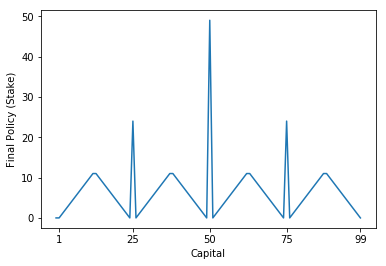

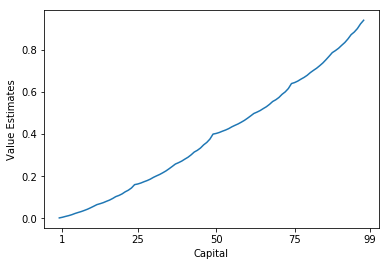

In [23]:
# creates object of the gambler environment
gambler_env = GamblersEnv()
policy, V = gamblers_value_iteration(gambler_env)

# plots policy obtained from running value iteration on the Gambler Env.
plt.figure()
plt.plot(policy)
plt.xticks([1,25,50,75,99])
plt.ylabel("Final Policy (Stake)")
plt.xlabel("Capital")
plt.show()

# plots the values obtained from running value iteration on the Gambler env.
plt.figure()
plt.plot(V[1:99])
plt.xticks([1,25,50,75,99])
plt.ylabel("Value Estimates")
plt.xlabel("Capital")
plt.show()


### Class of possible optimal solutions for the problem setting (100 capital, 0.4p) given in the problem.
##### There can be more than one optimal solutions to the Gambler's problem.
We can get a family of optimal solutions to the Gambler's problem based on the way in which we break ties.

*So, some of the optimal solutions for the problem are:*
1. Betting the maximum if the capital is below 50%. So, in this policy we bet maximum for capital below 50. And, just enough to get to goal capital if the capital(cash in hand) is above 50%.
2. Optimal Policy using simple argmax which breaks ties by picking the first maximum occurrence
![Otimal Policy using Argmax](./argmax.png)
3. Optimal solution obtained by breaking ties by picking last occurrence for argmax
![Optimal Policy using reverse Argmax](./last_occurrence.png)
4. Optimal solution obtained by breaking ties randomly
![Optimal Policy by breaking ties randomly](./random.png)

# Step 3:

Implementing value iteration for any arbritary Gym environemnt provided there is a perfect model of the environment as a MDP. In order for a OpenAI Gym environment to have this perfect model it must have nS, nA, and P as attributes.

* **P:** Represents the transition probabilities of the environment. P[s][a] is the tuple (prob, next_state, reward, done)
* **nS:** Number of states in the environment
* **nA:** Number of actions in the environment

Note that I have added a max iterations argument to this function. While this is not necessary, it ensures that we will never be stuck running forever due to a bad $\theta$.

In [24]:
def gym_value_iteration(env, theta=1e-4, gamma=1.0, max_iterations=1000):
    """
    Args:
        env: OpenAI Gym environment which has P, nS, and nA as attributes
        theta: Threshold used to determine accuracy of estimation
        gamma: Discount factor
        max_iterations: Maximum number of value iterations to run
    Returns:
        A tuple (policy, value function)
    """
    
    V = np.zeros(env.nS)
    policy = np.zeros(env.nS)
    iteration = 0
    
    while True:
        iteration += 1
        delta = 0
        for state in range(env.nS):
            v = V[state]
            UpdatedValues = bellmanUpdate(env, state, V, gamma)
            V[state] = np.max(UpdatedValues)
            delta = max(delta, np.abs(v - V[state]))
        
        if delta < theta:
            break
        
        if iteration > max_iterations:
            break

    # policy creation
    for state in range(env.nS):
        values = bellmanUpdate(env, state, V, gamma)
        
        # do not break ties randomly to obtain the frozen lake environment's optimal policy
        best_action = np.argmax(values)
        policy[state] = best_action 
        
    return policy, V

In [25]:
def bellmanUpdate(env, state, V, gamma):
    '''
    Args:
        env - environment on which the generalized value iteration is applied
        state - state (capital) whose value has to be evaluated and improved
        V - dict of values for the given environment
        gamma - discount factor
    Returns:
        a dict of values for taking each action from given state
    '''
    updatedVaues = np.zeros(env.nA)
    
    for action in range(env.nA):
        for prob,next_state,reward,done in env.P[state][action]:
            updatedVaues[action] += prob * (reward + gamma * V[next_state])
 
    return updatedVaues

# Step 4
### Test our implementation on the Frozen Lake environment

In [26]:
frozen_lake = FrozenLakeEnv()
policy, V = gym_value_iteration(frozen_lake)

# assert expected policy output is the same as our calculated policy ouputs
expected_policy = np.array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])
np.testing.assert_array_equal(policy, expected_policy)